<a href="https://colab.research.google.com/github/tutsilianna/Introduction_to_ML_and_Advanced_ML_Python/blob/main/Logistic%20Regression/Classifiers_Logistic_Regression_%7C_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

In tasks, use the implementation of logistic regression from the sklearn library:

`from sklearn.linear_model import LogisticRegression`

When training, use the following parameters: `random_state = 2019`, `solver = 'lbfgs'`:

`LogisticRegression(random_state = 2019, solver = 'lbfgs').fit(X, y)`

[Description of the implementation of logistic regression from the sklearn library.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

# Dataset description

[The provided dataset](https://drive.google.com/file/d/1qTELQc2Nvl8gx_PRWhuuo22eskHL2za2/view?usp=sharing) contains information about the passengers of the Titanic, which sank on the night of April 15, 1912. A number of passengers were rescued due to many different factors, including their gender, age, which deck their cabin was on, social status, etc.

The dataset consists of various features that describe information about the passengers. Each row of the table is an individual passenger, with all the information about that passenger contained in its row.

Dataset description:
- **Survived** (target): whether passanger survived or not (0 = No, 1 = Yes);
- **Pclass**: ticket class (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: gender (female или male)
- **Age**: age in years
- **SibSp**: no. of siblings/spouses aboard the Titanic
- **Parch**: no. of parents/children aboard the Titanic
- **Ticket**: ticket number
- **Fare**: passenger fare
- **Cabin**: cabin number
- **Embarked**: port of embarkation: (C = Cherbourg, Q = Queenstown, S = Southampton).

We need to solve the classification problem and learn to predict the target feature **Survived** (whether the passenger will survive) from the corresponding non-target features.


# Data preparation and exploratory analysis

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
data = pd.read_csv('/content/drive/MyDrive/itmo|AI_cources/titanic_train.csv', encoding = 'utf-8', delimiter=',')

In [58]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN


Find the number of missing values in the <code>age</code> column:

In [59]:
data['age'].isnull().sum()

199

Calculate the proportion of survivors.

In [60]:
round(data[data['survived'] == 1].shape[0] / data.shape[0], 3)

0.382

Determine the proportion of missing values within each feature and get rid of those features where the proportion of missing values is greater than a third. Also delete the column <code>ticket</code> as this information is unlikely to be useful.

In [61]:
data['age'].isnull().sum() / data.shape[0] > 1/3

False

In [62]:
data['cabin'].isnull().sum() / data.shape[0] > 1/3

True

In [63]:
data['home.dest'].isnull().sum() / data.shape[0] > 1/3

True

In [64]:
data.drop(axis=1, columns=['cabin', 'home.dest', 'ticket'], inplace=True)
data.isnull().sum()

pclass        0
survived      0
name          0
sex           0
age         199
sibsp         0
parch         0
fare          0
embarked      0
dtype: int64

From the dataset description, you can see that the columns <code>sibsp</code> and <code>parch</code> are essentially responsible for family size. Replace these two columns with the <code>fam_size</code> column, whose values will be calculated as the sum of the corresponding values in the columns <code>sibsp</code> and <code>parch</code>.

In [65]:
data['fam_size'] = data['sibsp'] + data['parch']
data.drop(axis=1, columns=['sibsp', 'parch'], inplace=True)
data.head()

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0


Calculate the sample mean of the column `fam_size`

In [66]:
round(data['fam_size'].mean(), 3)

0.866

The resulting dataset will be called **INITIAL** (the features discarded at this stage do not need to be returned at any of the subsequent stages of the task).

In [67]:
initial = data.copy(deep=True)

Based on available statistics, estimate the probability of survival if the passenger is a member of the particular category (this category is pecified in your individual assignment).

Calculate the number of `predictors` of the resulting dataset.

In [68]:
7

7

Based on available statistics, estimate the probability of survival if the passenger is a member of the following category: `female and pclass:1`

In [69]:
round(initial[(initial['sex'] == 'female') & (initial['pclass'] == 1) & (initial['survived'] == 1)].shape[0] / initial[(initial['sex'] == 'female') & (initial['pclass'] == 1)].shape[0],3)

0.971

Construct histograms of survivors and non-survivors by age.

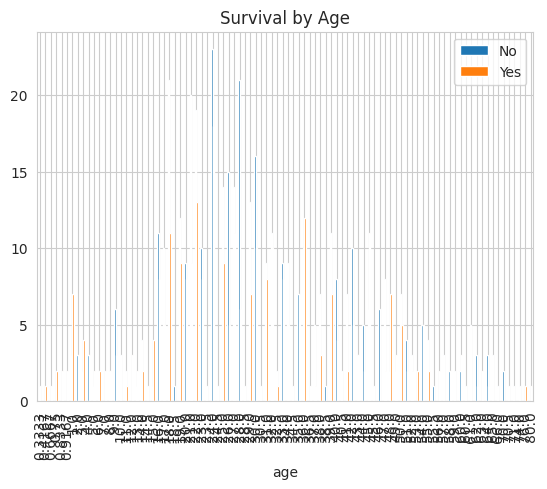

In [70]:
survival_by_age = initial.groupby(['age', 'survived']).size().unstack('survived')
survival_by_age.columns = ['No', 'Yes']
survival_by_age.plot.bar(title='Survival by Age');

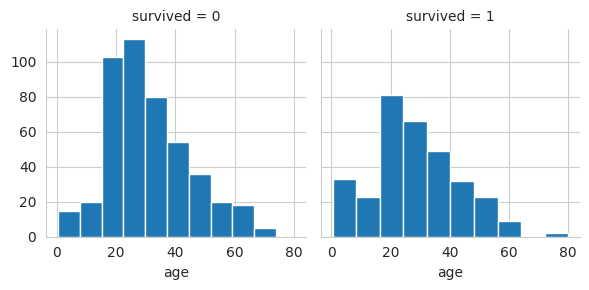

In [71]:
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

g = sns.FacetGrid(initial, col='survived')
g.map(plt.hist, 'age', bins=10);

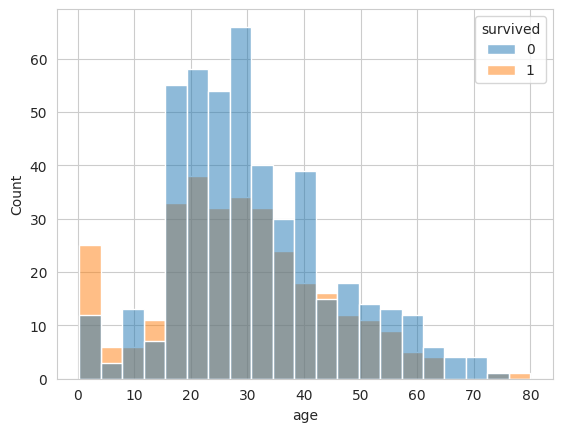

In [100]:
with sns.axes_style('whitegrid'):
    sns.histplot(data=data, x='age', hue='survived')

# Model based on numerical features

## Removing rows with missing values

As a base model, it makes sense to build a model with minimal effort.

Select only numeric attributes from the original dataset. Remove rows containing missing values. Use `train_test_split()` to split the dataset into training and test samples with the following parameters `test_size=0.2`, `random_state=35`. Use stratification by column survived.

Train `LogisticRegression()` model with the following parameters: `random_state=35, max_iter=1000` on training dataset, and evaluate the model on test dataset.

Compute <code>f1_score()</code> of the model on the test dataset (we recommend using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">the corresponding function</a> with default parameters).

In [72]:
base = initial.copy(deep=True)
base.drop(axis=1, columns=['name', 'sex', 'embarked'], inplace=True)
base.dropna(inplace=True)
base.head()

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0


In [73]:
X = base[['pclass', 'age', 'fare', 'fam_size']]
y = base[['survived']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35, stratify=y)

In [74]:
LogReg = LogisticRegression(random_state = 35, max_iter=1000).fit(X_train, y_train['survived'])

In [75]:
y_pred = LogReg.predict(X_test)
round(f1_score(y_test['survived'], y_pred), 3)

0.518

## Filling missing values with the mean

The quality of the resulting model leaves much to be desired. It makes sense to try to fill the missing values. Remove categorical features from the initial dataset, and fill missing values with the mean value of the column. The following steps are similar: splitting, training, evaluation.

Compute <code>f1_score()</code> of the model on the test dataset.

In [76]:
data_no_NaN = initial.copy(deep=True)
data_no_NaN.drop(axis=1, columns=['name', 'sex', 'embarked'], inplace=True)
data_no_NaN.isnull().sum()

pclass        0
survived      0
age         199
fare          0
fam_size      0
dtype: int64

In [77]:
data_no_NaN['age'].fillna(data_no_NaN['age'].mean(), inplace = True)
data_no_NaN.isnull().sum()

pclass      0
survived    0
age         0
fare        0
fam_size    0
dtype: int64

In [78]:
X1 = data_no_NaN[['pclass', 'age', 'fare', 'fam_size']]
y1 = data_no_NaN[['survived']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=35, stratify=y1)

In [79]:
LogReg1 = LogisticRegression(random_state = 35, max_iter=1000).fit(X_train1, y_train1['survived'])

In [80]:
y_pred1 = LogReg1.predict(X_test1)
round(f1_score(y_test1['survived'], y_pred1), 3)

0.483

## Filling missing values based on honorifics

Obviously, filling missing values in the <code>age</code> column with mean is not the smartest idea. Perhaps you should perform this procedure somehow more intelligently, for example, with an eye on appealing to the person.

You can notice that the initial dataset in the column contains information about the social status of the passenger, namely, there are appeals <code>Mr., Mrs., Dr.</code>, etc. Based on this information, we can try to make an assumption about the passenger's age.

Put the column <code>name</code> back into consideration. Create a separate <code>honorific</code> column and put the appeal values there.

Calculate the number of unique appeals.

In [165]:
data1 = initial.copy(deep=True)
data1.drop(axis=1, columns=['sex', 'embarked'], inplace=True)

In [166]:
data1['honoric'] = data1.name.str.extract(' ([A-Za-z]+)\.', expand=False)
data1.drop(axis=1, columns=['name'], inplace=True)

In [167]:
data1['honoric'].unique(), len(data1['honoric'].unique())

(array(['Miss', 'Mrs', 'Mr', 'Master', 'Mlle', 'Rev', 'Ms', 'Col', 'Dona',
        'Dr', 'Countess', 'Major', 'Don', 'Capt'], dtype=object),
 14)

Most likely, it makes sense to reduce the number of appeals, adding small groups to the more numerous ones, as there seems to be no fundamental difference between, for example, <code>Don</code> and <code>Mr</code>. Note that <code>Master</code> is a former appeal to a child, we will work with this appeal separately.




Make the following substitutions:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [168]:
data1['honoric'] = data1['honoric'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr')
data1['honoric'] = data1['honoric'].replace(['Dona', 'Countess'], 'Mrs')
data1['honoric'] = data1['honoric'].replace(['Mlle', 'Ms'], 'Miss')

In [169]:
data1['honoric'].unique(), len(data1['honoric'].unique())

(array(['Miss', 'Mrs', 'Mr', 'Master'], dtype=object), 4)

Calculate the proportion of rows with the <code>Master</code> value relative to the number of all males.

In [170]:
round(data1[data1['honoric'] == 'Master'].shape[0] / (data1[(data1['honoric'] == 'Master') | (data1['honoric'] == 'Mr')]).shape[0], 3)

0.072

Calculate the average age of the category `Master`.

In [171]:
master_age_mean = data1[data1['honoric'] == 'Master']['age'].mean()
round(master_age_mean, 3)

5.128

Fill the missing values in the column <code>age</code> with the mean corresponding to the mean of the <code>honorific</code> category.

Get rid of non-numeric features. Next steps are similar: splitting, training, evaluation.

Compute <code>f1_score()</code> of the model on the test dataset.

In [172]:
data1.isnull().sum()

pclass        0
survived      0
age         199
fare          0
fam_size      0
honoric       0
dtype: int64

In [173]:
miss_age_mean = data1[data1['honoric'] == 'Miss']['age'].mean()
mrs_age_mean = data1[data1['honoric'] == 'Mrs']['age'].mean()
mr_age_mean = data1[data1['honoric'] == 'Mr']['age'].mean()

In [174]:
data1.loc[(data1['honoric'] == 'Master') & (data1['age'].isna()), 'age'] = master_age_mean

data1.loc[(data1['honoric'] == 'Miss') & (data1['age'].isna()), 'age'] = miss_age_mean

data1.loc[(data1['honoric'] == 'Mrs') & (data1['age'].isna()), 'age'] = mrs_age_mean

data1.loc[(data1['honoric'] == 'Mr') & (data1['age'].isna()), 'age'] = mr_age_mean

<Axes: >

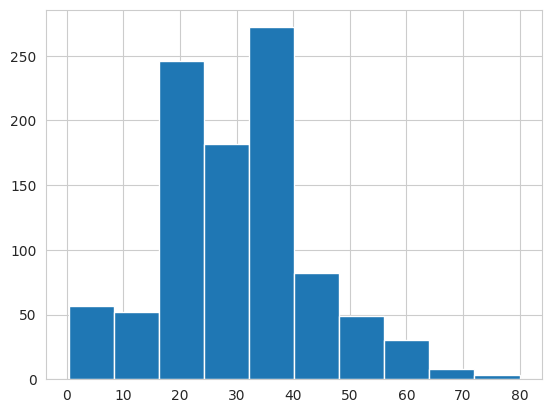

In [175]:
data1.age.hist()

In [176]:
data1.isnull().sum()

pclass      0
survived    0
age         0
fare        0
fam_size    0
honoric     0
dtype: int64

In [177]:
X2 = data1[['pclass', 'age', 'fare', 'fam_size']]
y2 = data1[['survived']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=35, stratify=y2)

In [178]:
LogReg2 = LogisticRegression(random_state = 35, max_iter=1000).fit(X_train2, y_train2['survived'])

In [179]:
y_pred2 = LogReg2.predict(X_test2)
round(f1_score(y_test2['survived'], y_pred2), 3)

0.466

# Model that uses categorical features

In the original dataset, fill the missing values in the column <code>age</code> with values based on the appeals (as in the previous step).

After that, drop the features <code>name</code> and <code>honorific</code>. They have fulfilled their function.

Perform <code>one-hot</code> encoding of the non-numeric features, for example, with <code>pd.get_dummies(drop_first=True)</code>. Then follow the familiar pattern: split, train, evaluate.

Compute <code>f1_score()</code> of the model on the test dataset.

In [182]:
final = initial.copy(deep=True)

<Axes: >

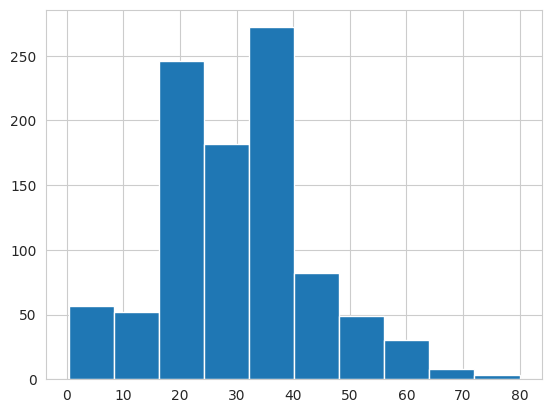

In [183]:
final['honoric'] = final.name.str.extract(' ([A-Za-z]+)\.', expand=False)
final.drop(axis=1, columns=['name'], inplace=True)

final['honoric'] = final['honoric'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr')
final['honoric'] = final['honoric'].replace(['Dona', 'Countess'], 'Mrs')
final['honoric'] = final['honoric'].replace(['Mlle', 'Ms'], 'Miss')

final.loc[(final['honoric'] == 'Master') & (final['age'].isna()), 'age'] = master_age_mean

final.loc[(final['honoric'] == 'Miss') & (final['age'].isna()), 'age'] = miss_age_mean

final.loc[(final['honoric'] == 'Mrs') & (final['age'].isna()), 'age'] = mrs_age_mean

final.loc[(final['honoric'] == 'Mr') & (final['age'].isna()), 'age'] = mr_age_mean

final.drop(axis=1, columns=['honoric'], inplace=True)

final.age.hist();

In [184]:
final.isnull().sum()

pclass      0
survived    0
sex         0
age         0
fare        0
embarked    0
fam_size    0
dtype: int64

In [185]:
final_ = pd.get_dummies(final, drop_first=True)
final_.head()

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,1,22.005765,7.7333,0,0,1,0
1,3,1,22.005765,7.7500,0,0,1,0
2,3,1,38.000000,7.2292,0,0,0,0
3,3,0,22.000000,7.8958,0,1,0,1
4,3,0,16.000000,9.5000,0,1,0,1


In [187]:
X3 = final_[['pclass', 'age', 'fare', 'fam_size', 'sex_male', 'embarked_Q', 'embarked_S']]
y3 = final_[['survived']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=35, stratify=y3)

In [188]:
LogReg3 = LogisticRegression(random_state = 35, max_iter=1000).fit(X_train3, y_train3['survived'])

In [189]:
y_pred3 = LogReg3.predict(X_test3)
round(f1_score(y_test3['survived'], y_pred3), 3)

0.71